In [1]:
import scipy.stats
import allutils.graph_generator
from allutils.general_PR import flowPR
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sys
import copy
import pickle
import uuid

In [2]:

#mode = sys.argv[1]
#beta = float(sys.argv[2])
mode = 'facebook'
beta = 0.0

do_plot = True
do_dump = False

n = 100
iters = 100000
alpha = 0.85
gamma = 1.0

weights = 'random'


In [11]:


G = allutils.graph_generator.weighted_DiGraph(n, seed = 1.0, mode = mode, weights = weights)
norm = sum([val for (node, val) in G.out_degree(weight='weight')])
sampling_edges = {e[:-1]: e[-1]['weight']/norm for e in G.edges(data=True)}
stream = [list(sampling_edges.keys())[i] for i in np.random.choice(range(len(sampling_edges)), size=iters)]#, p=sampling_edges.values()
personalization = {k: v / norm for k, v in G.out_degree(weight='weight')}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes()}
pr_basic = nx.pagerank(G, alpha=alpha, personalization=personalization, weight='weight')

RS_init, current_init = {}, {}    
RS, current, tau, spearman, pearson, error, x = flowPR(p_prime_nodes, pr_basic, stream, RS_init, current_init, iters = iters, beta = beta, gamma = gamma)


344
DiGraph with 100 nodes and 2913 edges
92110.99729802037


In [13]:

#1st change of sampling distribution:
G = allutils.graph_generator.change_weights(G)
norm = sum([val for (node, val) in G.out_degree(weight='weight')])
sampling_edges = {e[:-1]: e[-1]['weight']/norm for e in G.edges(data=True)}
stream = [list(sampling_edges.keys())[i] for i in np.random.choice(range(len(sampling_edges)), size=iters)]#, p=sampling_edges.values()
personalization = {k: v / norm for k, v in G.out_degree(weight='weight')}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes()}
pr_basic = nx.pagerank(G, alpha=alpha, personalization=personalization, weight='weight')


In [14]:

RS_1, current_1, tau_1, spearman_1, pearson_1, error_1, x_1 = flowPR(p_prime_nodes, pr_basic, stream, copy.deepcopy(RS), copy.deepcopy(current), iters = iters, beta = beta, gamma = gamma,  padding = iters)


192525.71951924148


In [16]:

#2nd change of sampling distribution:
G = allutils.graph_generator.change_weights(G)
norm = sum([val for (node, val) in G.out_degree(weight='weight')])
sampling_edges = {e[:-1]: e[-1]['weight']/norm for e in G.edges(data=True)}
stream = [list(sampling_edges.keys())[i] for i in np.random.choice(range(len(sampling_edges)), size=iters)]#, p=sampling_edges.values()
personalization = {k: v / norm for k, v in G.out_degree(weight='weight')}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes()}
pr_basic = nx.pagerank(G, alpha=alpha, personalization=personalization, weight='weight')


In [17]:

RS_2, current_2, tau_2, spearman_2, pearson_2, error_2, x_2 = flowPR(p_prime_nodes, pr_basic, stream, copy.deepcopy(RS_1), copy.deepcopy(current_1), iters = iters, beta = beta, gamma = gamma, padding = 2*iters)


292686.5275766786


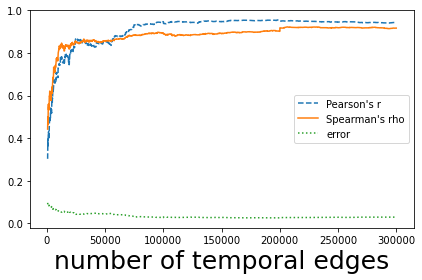

In [18]:

if do_dump:
    unique_out = str(beta).replace('.','-') + '_' + mode  + '_shift_beta_' + str(uuid.uuid4())
    pickle.dump([RS, pearson, spearman, tau, error, x,\
            RS_1, pearson_1, spearman_1, tau_1, error_1, x_1,\
            RS_2, pearson_2, spearman_2, tau_2, error_2, x_2], open(unique_out+".p", "wb"))

if do_plot:
    plt.figure('adaptation')
    
    x = list(x) + list(x_1) + list(x_2)

    plt.plot(x, pearson + pearson_1 + pearson_2, linestyle = '--')
    plt.plot(x, spearman + spearman_1 + spearman_2, linestyle = '-')
    #plt.plot(x, tau + tau_1 + tau_2, linestyle = '-.')
    plt.plot(x, error + error_1 + error_2, linestyle = ':')
    
    leg = ['Pearson\'s r', 'Spearman\'s rho', 'error']
    plt.legend(leg, loc=0)
    plt.xlabel('number of temporal edges', fontsize=25)
    plt.tight_layout()
    plt.savefig(mode+'_adaptation.pdf')
